# Chapter 12: A Language model from scratch

In [1]:
import requests
import gzip
import pandas as pd

# URL of the gzipped text file
url = "https://github.com/lsb/human-numbers/blob/trunk/one-hundred-thousand-numbers.txt.gz?raw=true"

# Downloading the file using requests
response = requests.get(url)
response.raise_for_status()  # This will raise an error if the download failed

# Unzipping the content
content = gzip.decompress(response.content).decode('utf-8')

# Since the file contains numbers, each number on a new line, we can split the content into a list
numbers = content.splitlines()

In [2]:
text = ' '.join(x for x in numbers)
tokens = text.split(' ')

tokens[:10]

['zero',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine']

In [3]:
vocab = sorted(list(set(tokens)))
len(vocab)

30

In [26]:
# token to numbers
word2idx = {w:i for i, w in enumerate(vocab)}
idx2word = {i:w for i, w in enumerate(vocab)}
nums = [word2idx[i] for i in tokens]
nums[:10]

[29, 14, 28, 25, 8, 6, 18, 15, 0, 11]

In [5]:
for idx in nums[:25]:
    print(idx, vocab[idx])

29 zero
14 one
28 two
25 three
8 four
6 five
18 six
15 seven
0 eight
11 nine
21 ten
3 eleven
26 twelve
22 thirteen
9 fourteen
4 fifteen
19 sixteen
16 seventeen
1 eighteen
12 nineteen
27 twenty
27 twenty
14 one
27 twenty
28 two


### dataset prep

In [6]:
dummy_tokens = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']  # Example list

for i in range(0, len(dummy_tokens) - 3, 1):
    three_tokens = dummy_tokens[i:i+3]  # Get a slice of three tokens
    next_token = dummy_tokens[i+3]      # Get the token immediately following the slice
    print(f"Three tokens: {three_tokens}, Next token: {next_token}, Step: {i}")

Three tokens: ['a', 'b', 'c'], Next token: d, Step: 0
Three tokens: ['b', 'c', 'd'], Next token: e, Step: 1
Three tokens: ['c', 'd', 'e'], Next token: f, Step: 2
Three tokens: ['d', 'e', 'f'], Next token: g, Step: 3
Three tokens: ['e', 'f', 'g'], Next token: h, Step: 4
Three tokens: ['f', 'g', 'h'], Next token: i, Step: 5
Three tokens: ['g', 'h', 'i'], Next token: j, Step: 6
Three tokens: ['h', 'i', 'j'], Next token: k, Step: 7


In [7]:
### predict next token based on three previous tokens; book uses step size of 3 which has no overlap, i prefer 1
[(tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-3, 1)][2000:2020] # change from 4-2 to 3-1

[(['hundred', 'ninety', 'three'], 'five'),
 (['ninety', 'three', 'five'], 'hundred'),
 (['three', 'five', 'hundred'], 'ninety'),
 (['five', 'hundred', 'ninety'], 'four'),
 (['hundred', 'ninety', 'four'], 'five'),
 (['ninety', 'four', 'five'], 'hundred'),
 (['four', 'five', 'hundred'], 'ninety'),
 (['five', 'hundred', 'ninety'], 'five'),
 (['hundred', 'ninety', 'five'], 'five'),
 (['ninety', 'five', 'five'], 'hundred'),
 (['five', 'five', 'hundred'], 'ninety'),
 (['five', 'hundred', 'ninety'], 'six'),
 (['hundred', 'ninety', 'six'], 'five'),
 (['ninety', 'six', 'five'], 'hundred'),
 (['six', 'five', 'hundred'], 'ninety'),
 (['five', 'hundred', 'ninety'], 'seven'),
 (['hundred', 'ninety', 'seven'], 'five'),
 (['ninety', 'seven', 'five'], 'hundred'),
 (['seven', 'five', 'hundred'], 'ninety'),
 (['five', 'hundred', 'ninety'], 'eight')]

In [8]:
import torch

# Assuming 'mps_device' is defined as your MPS device
mps_device = torch.device('mps')

In [9]:
# create dataset karpathy style
xs = []
ys = []
for i in range(0, len(tokens) - 3, 1):
    three_tokens = torch.tensor(nums[i:i+3])  # Get a slice of three tokens
    next_token = torch.tensor(nums[i+3])      # Get the token immediately following the slice
    xs.append(three_tokens)
    ys.append(next_token)

In [53]:
from collections import Counter

def get_most_common_scalar(data):
    """given list of scalars, find the most comon scalar value"""
    counter = Counter(data)
    most_common = counter.most_common(1)[0][0]
    return idx2word[most_common.item()]

get_most_common_scalar(ys)

'three'

In [54]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

class LLMModel1(nn.Module):
    def __init__(self, vocab_size, n_hidden):
        super(LLMModel1, self).__init__()  # Initialize the superclass
        self.i_h = nn.Embedding(vocab_size, n_hidden) #vocab to hidden
        self.h_h = nn.Linear(n_hidden, n_hidden) # hidden to hidden
        self.h_o = nn.Linear(n_hidden, vocab_size) # hidden to vocab (logits)
        
    def forward(self, x):
        """hidden states are accumulated. subsequent hidden state is added to embedding of next token before being passed through next linear layer and ReLU"""
        # create first hidden state from first word
        # embed --> linear --> relu
        h = F.relu(self.h_h(self.i_h(x[:, 0])))

        # second hidden state from second word
        h = h + self.i_h(x[:, 1])
        h = F.relu(self.h_h(h))

        # hidden state from third word
        h = h + self.i_h(x[:, 2])
        h = F.relu(self.h_h(h))
        return self.h_o(h)

In [55]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming X and Y are your data tensors
X = torch.stack(xs)
Y = torch.stack(ys)
dataset = TensorDataset(X, Y)

# Calculate the sizes of splits
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset (this method shuffles the data)
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Split the dataset without shuffling
train_dataset = TensorDataset(X[:train_size], Y[:train_size])
val_dataset = TensorDataset(X[train_size:], Y[train_size:])

# Create data loaders with drop_last=True to ensure all batches have the same size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)


In [56]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in progress_bar:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            avg_loss = total_loss / total
            accuracy = 100 * correct / total
            progress_bar.set_postfix(loss=avg_loss, accuracy=f'{accuracy:.2f}%')

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        with torch.no_grad():
            for batch in progress_bar:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                avg_loss = total_loss / total
                accuracy = 100 * correct / total
                progress_bar.set_postfix(loss=avg_loss, accuracy=f'{accuracy:.2f}%')

        val_losses.append(total_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

    return train_losses, val_losses, train_accuracies, val_accuracies, model


In [57]:
vocab_size = len(vocab)
n_hidden = 64
model = LLMModel1(vocab_size, n_hidden)
model.to(mps_device)  # Move model to MPS device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 2
device = mps_device

train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

Epoch 2/2 [Validation]: 100%|██████████| 1940/1940 [00:05<00:00, 365.05it/s, accuracy=40.01%, loss=0.0386]


In [109]:
# print number of params in model
def print_params(model):
    num_params = 0
    for param in model.parameters():
        num_params += param.numel()
    print(f"#Params: {num_params}")
    return num_params

def predict_next_word(model, input_sequence, word2idx, idx2word):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Convert the input sequence to a tensor of word indices
    input_indices = [word2idx[word] for word in input_sequence]
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0)  # Add a batch dimension
    input_tensor = input_tensor.to(device)  # Move the tensor to the appropriate device
    
    # Get the prediction
    with torch.no_grad():  # No need to track gradients for prediction
        output = model(input_tensor)
    
    # Get the predicted word index
    _, predicted_index = torch.max(output, 1) # output is of shape (1, vocab_size)
    predicted_index = predicted_index.item()  # Convert to a Python integer
    
    # Convert the predicted index to the corresponding word
    predicted_word = idx2word[predicted_index]
    print(f'input sequence: {input_sequence}.\nprediction: {predicted_word}')
    model.reset()


print_params(model)

# Example usage
input_sequence = ['one', 'two', 'three']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['twenty', 'one', 'twenty']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['zero', 'one', 'two']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['one', 'hundred', 'one']
predict_next_word(model, input_sequence, word2idx, idx2word)


#Params: 8030
input sequence: ['one', 'two', 'three'].
prediction: eighty
input sequence: ['twenty', 'one', 'twenty'].
prediction: nine
input sequence: ['zero', 'one', 'two'].
prediction: thousand
input sequence: ['one', 'hundred', 'one'].
prediction: eighty


In [59]:
input_sequence = ['twenty', 'one', 'twenty']

model.eval()
    
# Convert the input sequence to a tensor of word indices
input_indices = [word2idx[word] for word in input_sequence]
input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0)  # Add a batch dimension
input_tensor = input_tensor.to(device)  # Move the tensor to the appropriate device

with torch.no_grad():  # No need to track gradients for prediction
    output = model(input_tensor)

_, predicted_index = torch.max(output, 1) # output is of shape (1, vocab_size)
predicted_index = predicted_index.item()  # Convert to a Python integer
    
# Convert the predicted index to the corresponding word
predicted_word = idx2word[predicted_index]

predicted_word

'thousand'

In [60]:
output.shape

torch.Size([1, 30])

In [61]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy if provided
    if train_accuracies and val_accuracies:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
        plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()


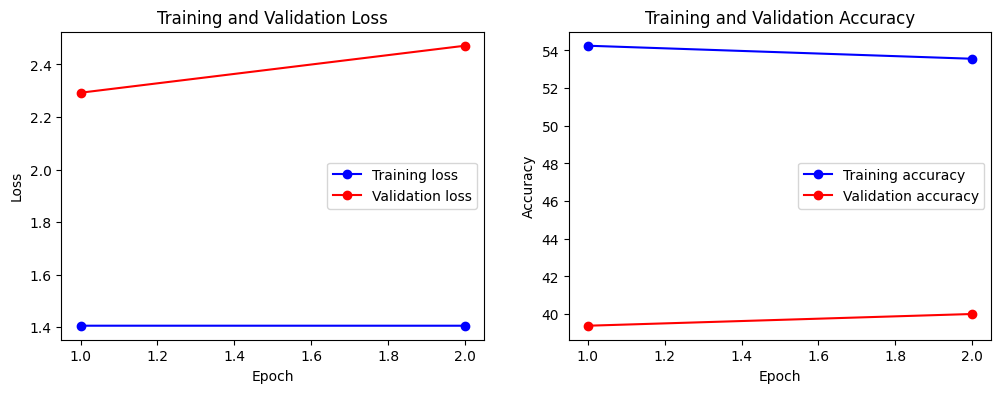

In [62]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

### refactor to RNN

In [63]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

class LLMModel2(nn.Module):
    def __init__(self, vocab_size, n_hidden):
        super(LLMModel2, self).__init__()  # Initialize the superclass
        self.i_h = nn.Embedding(vocab_size, n_hidden) #vocab to hidden
        self.h_h = nn.Linear(n_hidden, n_hidden) # hidden to hidden
        self.h_o = nn.Linear(n_hidden, vocab_size) # hidden to vocab (logits)
        
    def forward(self, x):
        """hidden states are accumulated. subsequent hidden state is added to embedding of next token before being passed through next linear layer and ReLU"""
        h = 0
        for i in range(3):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)



In [64]:
torch.mps.empty_cache()

In [65]:
vocab_size = len(vocab)
n_hidden = 64
model = LLMModel2(vocab_size, n_hidden)
model.to(mps_device)  # Move model to MPS device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

Epoch 2/2 [Validation]: 100%|██████████| 1940/1940 [00:05<00:00, 357.87it/s, accuracy=40.08%, loss=0.0376]


In [66]:
# Example usage
input_sequence = ['one', 'two', 'three']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['twenty', 'one', 'twenty']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['zero', 'one', 'two']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['one', 'hundred', 'one']
predict_next_word(model, input_sequence, word2idx, idx2word)

input sequence: ['one', 'two', 'three'].
prediction: thousand
input sequence: ['twenty', 'one', 'twenty'].
prediction: five
input sequence: ['zero', 'one', 'two'].
prediction: thousand
input sequence: ['one', 'hundred', 'one'].
prediction: eighty


### maintaining hidden state

- instead of resetting to 0 for each forward

In [67]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

class LLMModel3(nn.Module):
    def __init__(self, vocab_size, n_hidden):
        super(LLMModel3, self).__init__()  # Initialize the superclass
        self.i_h = nn.Embedding(vocab_size, n_hidden) #vocab to hidden
        self.h_h = nn.Linear(n_hidden, n_hidden) # hidden to hidden
        self.h_o = nn.Linear(n_hidden, vocab_size) # hidden to vocab (logits)
        self.h = 0
        
    def forward(self, x):
        """hidden states are accumulated. subsequent hidden state is added to embedding of next token before being passed through next linear layer and ReLU"""
        for i in range(3):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach() # stop tracking previous gradients
        return out

    def reset(self):
        # Resets or reinitializes the hidden state to zero
        self.h = 0


# detach means we only calculate gradients of previous 3 steps (for loop) aka the steps used to calculate this self.h; this is used to avoid vanishing/exploding graidnets

In [68]:
torch.mps.empty_cache()


model = LLMModel3(vocab_size, n_hidden)
model.to(mps_device)  # Move model to MPS device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

Epoch 2/2 [Validation]: 100%|██████████| 1940/1940 [00:05<00:00, 353.96it/s, accuracy=38.95%, loss=0.0394]


In [70]:
print_params(model)

#Params: 8030


8030

In [71]:
model

LLMModel3(
  (i_h): Embedding(30, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=30, bias=True)
)

In [110]:
model.reset()

# Example usage
input_sequence = ['one', 'two', 'three']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['twenty', 'one', 'twenty']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['zero', 'one', 'two']
predict_next_word(model, input_sequence, word2idx, idx2word)

input_sequence = ['one', 'hundred', 'one']
predict_next_word(model, input_sequence, word2idx, idx2word)



input sequence: ['one', 'two', 'three'].
prediction: thousand
input sequence: ['twenty', 'one', 'twenty'].
prediction: nine
input sequence: ['zero', 'one', 'two'].
prediction: thousand
input sequence: ['one', 'hundred', 'one'].
prediction: eighty


slight boost in performance...

### now instead of outputting one word per three input words, output after each step...

this gives it more signal for back prop

In [111]:
sl = 16
nums[i:i+sl], nums[i+1:i+sl+1]

([11, 10, 13, 11], [10, 13, 11])

In [112]:
# create dataset karpathy style
sl = 16

xs = []
ys = []
for i in range(0, len(nums) - sl-1, 1):
    sixteen_tokens = torch.tensor(nums[i:i+16])  # Get a slice of three tokens
    next_sixteen_tokens = torch.tensor(nums[i+1: i+sl+1])      # Get the token immediately following the slice
    xs.append(sixteen_tokens)
    ys.append(next_sixteen_tokens)

# Assuming X and Y are your data tensors
X = torch.stack(xs)
Y = torch.stack(ys)
dataset = TensorDataset(X, Y)

# Calculate the sizes of splits
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset (this method shuffles the data)
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Split the dataset without shuffling
train_dataset = TensorDataset(X[:train_size], Y[:train_size])
val_dataset = TensorDataset(X[train_size:], Y[train_size:])

# Create data loaders with drop_last=True to ensure all batches have the same size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)


In [113]:
i_ = 1
xs[i_], ys[i_]

for num in xs[i_]:
    print(vocab[num])

print('\n')

for num in ys[i_]:
    print(vocab[num])

one
two
three
four
five
six
seven
eight
nine
ten
eleven
twelve
thirteen
fourteen
fifteen
sixteen


two
three
four
five
six
seven
eight
nine
ten
eleven
twelve
thirteen
fourteen
fifteen
sixteen
seventeen


In [114]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

class LLMModel4(nn.Module):
    def __init__(self, vocab_size, n_hidden):
        super(LLMModel4, self).__init__()  # Initialize the superclass
        self.i_h = nn.Embedding(vocab_size, n_hidden) #vocab to hidden
        self.h_h = nn.Linear(n_hidden, n_hidden) # hidden to hidden
        self.h_o = nn.Linear(n_hidden, vocab_size) # hidden to vocab (logits)
        self.h = 0
        
    def forward(self, x):
        """output a prediction after each word

        will return outs as shape batch_size x seq_len x vocab_sz
        """
        outs = [] # (batch_size x vocab_sz)
        for i in range(sl): # CHANGED TO SL
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach() # stop tracking previous gradients
        return torch.stack(outs, dim=1)

    def reset(self):
        # Resets or reinitializes the hidden state to zero
        self.h = 0


In [115]:
# dumb but we'll update the function for outputs.shape

from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in progress_bar:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # FLATTTEN AND RESHAPE
            outputs = outputs.view(-1, vocab_size)
            labels = labels.view(-1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            avg_loss = total_loss / total
            accuracy = 100 * correct / total
            progress_bar.set_postfix(loss=avg_loss, accuracy=f'{accuracy:.2f}%')

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        with torch.no_grad():
            for batch in progress_bar:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                outputs = outputs.view(-1, vocab_size)
                labels = labels.view(-1)

                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                avg_loss = total_loss / total
                accuracy = 100 * correct / total
                progress_bar.set_postfix(loss=avg_loss, accuracy=f'{accuracy:.2f}%')

        val_losses.append(total_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

    return train_losses, val_losses, train_accuracies, val_accuracies

In [116]:
torch.mps.empty_cache()


model = LLMModel4(vocab_size, n_hidden)
model.to(mps_device)  # Move model to MPS device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

Epoch 5/5 [Validation]: 100%|██████████| 1940/1940 [00:11<00:00, 163.96it/s, accuracy=28.78%, loss=0.00253]


In [119]:
# Define your sequence length
sl = 16

model.reset()

# Make sure to have your word2idx dictionary ready to convert words to indices
input_sequence = ['one', 'hundred', 'one', 
                  'one', 'hundred', 'two',
                  'one', 'hundred', 'three', 
                  'one', 'hundred', 'four',
                  'one', 'hundred', 'five',
                  'one']  # sequence of length sl

# Convert input sequence to tensor of word indices
input_indices = [word2idx[word] for word in input_sequence]
input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)  # Move to the appropriate device

# Set model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    logits = model(input_tensor)  # Logits will have shape [1, sl, vocab_size] since we did unsqueeze

# If you want to get the most likely word predictions for each position in the sequence:
predictions = torch.argmax(logits, dim=2)  # This will give you [1, sl] tensor of word indices

# Convert predicted indices to words
predicted_words = [idx2word[idx.item()] for idx in predictions[0]]
predicted_words

['thousand',
 'eighty',
 'eighty',
 'seventy',
 'eighty',
 'seventy',
 'seventy',
 'eighty',
 'seventy',
 'seventy',
 'eighty',
 'seventy',
 'seventy',
 'eighty',
 'seventy',
 'seventy']

### multi-layer RNNs 

will suffer from exploding...vanishing gradients...

In [120]:
### LSTM

class LSTMCell(nn.Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh) # since we stack ni + nh into one tensor
        self.input_gate = nn.Linear(ni + nh, nh)
        self.cell_gate = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)
    
    def forward(self, input, state):
        h, c = state # hidden state and cell state 
        h = torch.stack([h, input], dim=1) # stack h and input together

        # forget cell state
        forget = torch.sigmoid(self.forget_gate(h)) # linear then sigmoid will squash values between 0 and 1
        c = c * forget # multiply by forget gate; aka what should we forget or remember

        # update cell state
        inp = torch.sigmoid(self.input_gate(h)) # what should we update; will be between 0 and 1
        cell = torch.tanh(self.cell_gate(h)) # what should the updated values be; will be between -1 and 1
        c = c + (inp * cell)

        # generate new hidden state, using h and c
        out = torch.sigmoid(self.output_gate(h)) # between 0 and 1
        h = out * torch.tanh(c) # multipled by tanh which is between -1 and 1
        return h, (h, c)
    
### Refactor for speed into one giant matrix multiplication
    
class LSTMCell(nn.Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni, 4 * nh)
        self.hh = nn.Linear(nh, 4 * nh)
    
    def forward(self, input, state):
        h, c = state # hidden state and cell state 
        # One big matmul for all gates
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate, forgetgate, outgate = map(torch.sigmoid, gates[:3]) 
        cellgate = gates[3].tanh()

        c = (forgetgate * c) + (ingate * cellgate)
        h = outgate * c.tanh()
        return h, (h, c)


In [123]:
t = torch.arange(0, 10); t

t.chunk(2)

(tensor([0, 1, 2, 3, 4]), tensor([5, 6, 7, 8, 9]))

```
x * ih -> [batch_size, ni] * [ni, 4*nh] = [batch_size, 4*nh]
h * hh -> [batch_size, nh] * [nh, 4*nh] = [batch_size, 4*nh]
gates = (x * ih) + (h * hh) -> [batch_size, 4*nh]

ingate, forgetgate, outgate, cellgate = gates.chunk(4, 1)


ingate = sigmoid([batch_size, nh])
forgetgate = sigmoid([batch_size, nh])
outgate = sigmoid([batch_size, nh])
cellgate = tanh([batch_size, nh])

c = (forgetgate * c) + (ingate * tanh(cellgate))
h = outgate * tanh(c)
```


### detour of detach

In [ ]:
import torch

# Creating a simple computation graph
x = torch.tensor([2.], requires_grad=True)
y = x * 2

# Without detach
z = y * y  # z = (x * 2) * (x * 2) = 4x^2
z.backward()  # Computes gradients for the whole graph
gradients_without_detach = x.grad.item()  # Should be dz/dx = 8x, which is 16 when x = 2

# Resetting gradients
x.grad.data.zero_()

# With detach
y_detached = y.detach()  # y_detached is a new tensor with the same value as y but no history of operations
# No need to call z.backward() because y_detached has no grad_fn
# and thus won't contribute to gradients in x

# The gradient of x should still be zero since the detached part does not contribute to the computation
gradients_with_detach = x.grad.item()

gradients_without_detach, gradients_with_detach


In [ ]:
## torch.stack()
lst = [torch.rand(2, 3) for i in range(3)]
print([x.shape for x in lst])

# stacking on dimension 1 maintains batch dimension, second dimension (1) becomes the timesteps
torch.stack(lst, dim=1).shape, torch.stack(lst, dim=1)

In [ ]:
torch.stack(lst, dim=0).shape, torch.stack(lst, dim=0)